In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

# высокое качество графиков
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300

print("Ready")

Ready


In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

# ----------------------------
# Config
# ----------------------------
N_USERS = 5000
CAMPAIGN_START = pd.Timestamp("2024-01-01 00:00:00")
FIRST_VISIT_SPREAD_DAYS = 7

#P_SIGNUP_GIVEN_VISIT = 0.82
#P_TRIAL_GIVEN_SIGNUP = 0.88
#P_PURCHASE_GIVEN_TRIAL = 0.80

P_SIGNUP_GIVEN_VISIT = 0.25
P_TRIAL_GIVEN_SIGNUP = 0.50
P_PURCHASE_GIVEN_TRIAL = 0.30

GAP_VISIT_TO_SIGNUP = (5*60, 3*24*60*60)
GAP_SIGNUP_TO_TRIAL = (5*60, 7*24*60*60)
GAP_TRIAL_TO_PURCHASE = (5*60, 14*24*60*60)

MAX_EXTRA_VISITS_BEFORE_SIGNUP = 3
MAX_EXTRA_VISITS_AFTER_SIGNUP = 2
REVISIT_GAP = (30*60, 3*24*60*60)

SOURCES = np.array(["ads", "organic", "email", "referral"])
SOURCE_P = np.array([0.40, 0.30, 0.20, 0.10])

DEVICES = np.array(["mobile", "desktop"])
DEVICE_P = np.array([0.70, 0.30])


def rand_seconds(a, b):
    return int(np.random.randint(a, b + 1))


def sample_revenue():
    return float(np.random.gamma(shape=3.0, scale=20.0))


# ----------------------------
# 1) First visit time for each incoming person
# ----------------------------
first_visit_times = np.array([
    CAMPAIGN_START + pd.to_timedelta(
        rand_seconds(0, FIRST_VISIT_SPREAD_DAYS * 24 * 60 * 60),
        unit="s"
    )
    for _ in range(N_USERS)
], dtype="datetime64[ns]")

# Sort by first visit time: this defines the "arrival order"
order = np.argsort(first_visit_times)

# Assign user_id = 1..N_USERS strictly by arrival order
# user_id 1 is the earliest first-visit timestamp, then 2, etc.
arrival_rank = np.empty(N_USERS, dtype=int)
arrival_rank[order] = np.arange(1, N_USERS + 1)

# Base visits: EVERY user has exactly one first visit, and user_id matches arrival order
base_visits = pd.DataFrame({
    "user_id": arrival_rank,
    "event": "visit",
    "timestamp": first_visit_times,
    "source": np.random.choice(SOURCES, size=N_USERS, p=SOURCE_P),
    "device": np.random.choice(DEVICES, size=N_USERS, p=DEVICE_P),
    "revenue": 0.0
})

rows = []

# ----------------------------
# 2) Build journeys, iterating in arrival order (so it's easy to reason about)
# ----------------------------
for idx in order:
    user_id = int(arrival_rank[idx])
    t = pd.Timestamp(first_visit_times[idx])

    # Extra visits before signup
    n_extra_before = np.random.randint(0, MAX_EXTRA_VISITS_BEFORE_SIGNUP + 1)
    for _ in range(n_extra_before):
        t = t + pd.to_timedelta(rand_seconds(*REVISIT_GAP), unit="s")
        rows.append({
            "user_id": user_id,
            "event": "visit",
            "timestamp": t,
            "source": np.random.choice(SOURCES, p=SOURCE_P),
            "device": np.random.choice(DEVICES, p=DEVICE_P),
            "revenue": 0.0,
        })

    # Signup
    if np.random.rand() > P_SIGNUP_GIVEN_VISIT:
        continue

    t = t + pd.to_timedelta(rand_seconds(*GAP_VISIT_TO_SIGNUP), unit="s")
    rows.append({
        "user_id": user_id,
        "event": "signup",
        "timestamp": t,
        "source": np.random.choice(SOURCES, p=SOURCE_P),
        "device": np.random.choice(DEVICES, p=DEVICE_P),
        "revenue": 0.0,
    })

    # Extra visits after signup
    n_extra_after = np.random.randint(0, MAX_EXTRA_VISITS_AFTER_SIGNUP + 1)
    t_vis = t
    for _ in range(n_extra_after):
        t_vis = t_vis + pd.to_timedelta(rand_seconds(*REVISIT_GAP), unit="s")
        rows.append({
            "user_id": user_id,
            "event": "visit",
            "timestamp": t_vis,
            "source": np.random.choice(SOURCES, p=SOURCE_P),
            "device": np.random.choice(DEVICES, p=DEVICE_P),
            "revenue": 0.0,
        })

    # Trial
    if np.random.rand() > P_TRIAL_GIVEN_SIGNUP:
        continue

    t = t + pd.to_timedelta(rand_seconds(*GAP_SIGNUP_TO_TRIAL), unit="s")
    rows.append({
        "user_id": user_id,
        "event": "trial_start",
        "timestamp": t,
        "source": np.random.choice(SOURCES, p=SOURCE_P),
        "device": np.random.choice(DEVICES, p=DEVICE_P),
        "revenue": 0.0,
    })

    # Purchase
    if np.random.rand() > P_PURCHASE_GIVEN_TRIAL:
        continue

    t = t + pd.to_timedelta(rand_seconds(*GAP_TRIAL_TO_PURCHASE), unit="s")
    rows.append({
        "user_id": user_id,
        "event": "purchase",
        "timestamp": t,
        "source": np.random.choice(SOURCES, p=SOURCE_P),
        "device": np.random.choice(DEVICES, p=DEVICE_P),
        "revenue": sample_revenue(),
    })


# ----------------------------
# 3) Global event stream (realistic event log)
# ----------------------------
df = pd.concat([base_visits, pd.DataFrame(rows)], ignore_index=True)
df = df.sort_values("timestamp").reset_index(drop=True)

print("df.shape:", df.shape)
print("Unique users:", df["user_id"].nunique())
df.head(50)

df.shape: (15652, 6)
Unique users: 5000


,user_id,event,timestamp,source,device,revenue
0,1,visit,2024-01-01 00:02:06,referral,mobile,0.0
1,2,visit,2024-01-01 00:02:39,ads,mobile,0.0
2,3,visit,2024-01-01 00:06:30,ads,desktop,0.0
3,4,visit,2024-01-01 00:06:44,referral,mobile,0.0
4,5,visit,2024-01-01 00:15:17,email,mobile,0.0
5,6,visit,2024-01-01 00:17:31,email,desktop,0.0
6,7,visit,2024-01-01 00:17:42,ads,desktop,0.0
7,8,visit,2024-01-01 00:20:52,ads,mobile,0.0
8,9,visit,2024-01-01 00:25:39,email,mobile,0.0
9,10,visit,2024-01-01 00:31:21,ads,mobile,0.0


In [3]:
# 1) What time range do the first N events cover?
N = 1000
print("First N events time range:")
print(df.loc[:N-1, "timestamp"].min(), " -> ", df.loc[:N-1, "timestamp"].max())

print("\nEvent distribution in first N events:")
print(df.loc[:N-1, "event"].value_counts())

# 2) When does the first signup happen?
first_signup_row = df[df["event"] == "signup"].head(1)
print("\nFirst signup row:")
print(first_signup_row[["timestamp", "user_id", "source", "device"]])

First N events time range:
2024-01-01 00:02:06  ->  2024-01-02 06:15:40

Event distribution in first N events:
event
visit     987
signup     13
Name: count, dtype: int64

First signup row:
              timestamp  user_id source   device
201 2024-01-01 07:18:30       82    ads  desktop


In [4]:
# === 1) Find the first purchase event ===

first_purchase_row = df[df["event"] == "purchase"].head(1)

print("First purchase event:")
print(first_purchase_row[["timestamp", "user_id", "source", "device", "revenue"]])


# === 2) Time difference from campaign start ===

campaign_start = df["timestamp"].min()
first_purchase_time = first_purchase_row["timestamp"].iloc[0]

print("\nTime since campaign start:")
print(first_purchase_time - campaign_start)


# === 3) How many events happened before the first purchase ===

events_before_purchase = df[df["timestamp"] < first_purchase_time].shape[0]

print("\nNumber of events before first purchase:")
print(events_before_purchase)

First purchase event:
               timestamp  user_id source  device    revenue
8190 2024-01-06 18:05:58      170    ads  mobile  120.69711

Time since campaign start:
5 days 18:03:52

Number of events before first purchase:
8190


In [5]:
print("Shape:", df.shape)

Shape: (15652, 6)


In [6]:
print("Unique users:", df["user_id"].nunique())

Unique users: 5000


In [7]:
print("Time range:")
print(df["timestamp"].min(), "→", df["timestamp"].max())

Time range:
2024-01-01 00:02:06 → 2024-02-02 15:08:54


In [8]:
print("Event distribution:")
print(df["event"].value_counts())

Event distribution:
event
visit          13663
signup          1206
trial_start      602
purchase         181
Name: count, dtype: int64


In [9]:
expected_users = set(range(1, 5001))
actual_users = set(df["user_id"].unique())

missing_users = expected_users - actual_users
missing_users

set()

In [10]:
visits_per_user = df[df["event"]=="visit"].groupby("user_id").size()
print("Avg visits per user:", visits_per_user.mean())
print("Share with only 1 visit:", (visits_per_user==1).mean())
print("Max visits:", visits_per_user.max())

Avg visits per user: 2.7326
Share with only 1 visit: 0.214
Max visits: 6


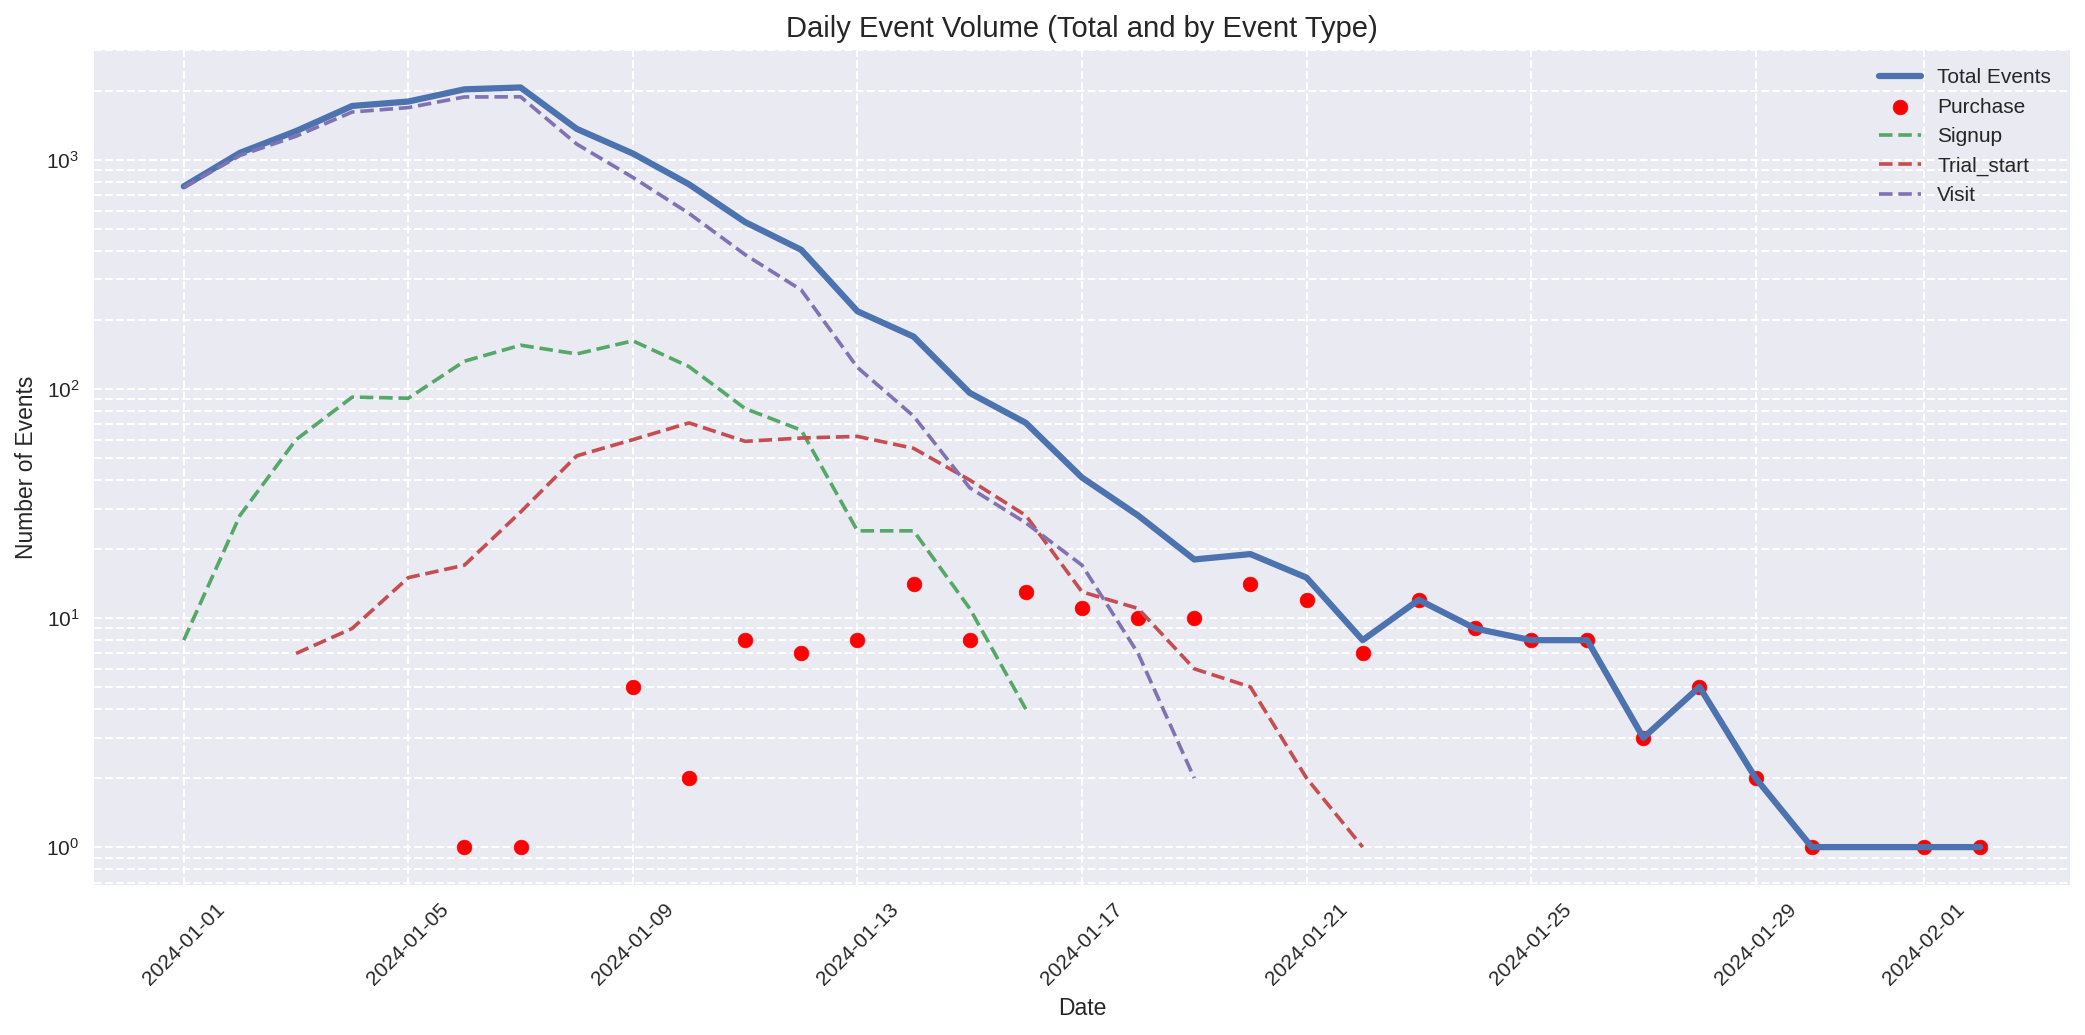

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure timestamp is datetime
df["date"] = df["timestamp"].dt.date

# --- Total events per day ---
daily_total = (
    df.groupby("date")
      .size()
      .rename("total_events")
)

# --- Events per day by type ---
daily_by_event = (
    df.groupby(["date", "event"])
      .size()
      .unstack(fill_value=0)
)

# --- Sanity check ---
check = daily_by_event.sum(axis=1)
assert (check == daily_total).all(), "Mismatch between total and event breakdown!"

# --- Replace zeros with NaN (for clean log plot) ---
daily_total = daily_total.replace(0, np.nan)
daily_by_event = daily_by_event.replace(0, np.nan)

# --- Plot ---
plt.figure(figsize=(14, 7))

# Total events (bold line)
plt.plot(
    daily_total.index,
    daily_total.values,
    linewidth=3,
    label="Total Events"
)

# Event types
for col in daily_by_event.columns:

    if col == "purchase":
        # Purchases as dots
        plt.scatter(
            daily_by_event.index,
            daily_by_event[col],
            s=50,
            label=col.capitalize(),
            color = 'red'
        )
    else:
        # Other events as dashed lines
        plt.plot(
            daily_by_event.index,
            daily_by_event[col],
            linestyle="--",
            label=col.capitalize()
        )

# Log scale
plt.yscale("log")

# Grid for log scale
plt.grid(True, which="both", linestyle="--", alpha=1.0)

plt.title("Daily Event Volume (Total and by Event Type)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

event
visit          5000
signup         1206
trial_start     602
purchase        181
Name: user_id, dtype: int64


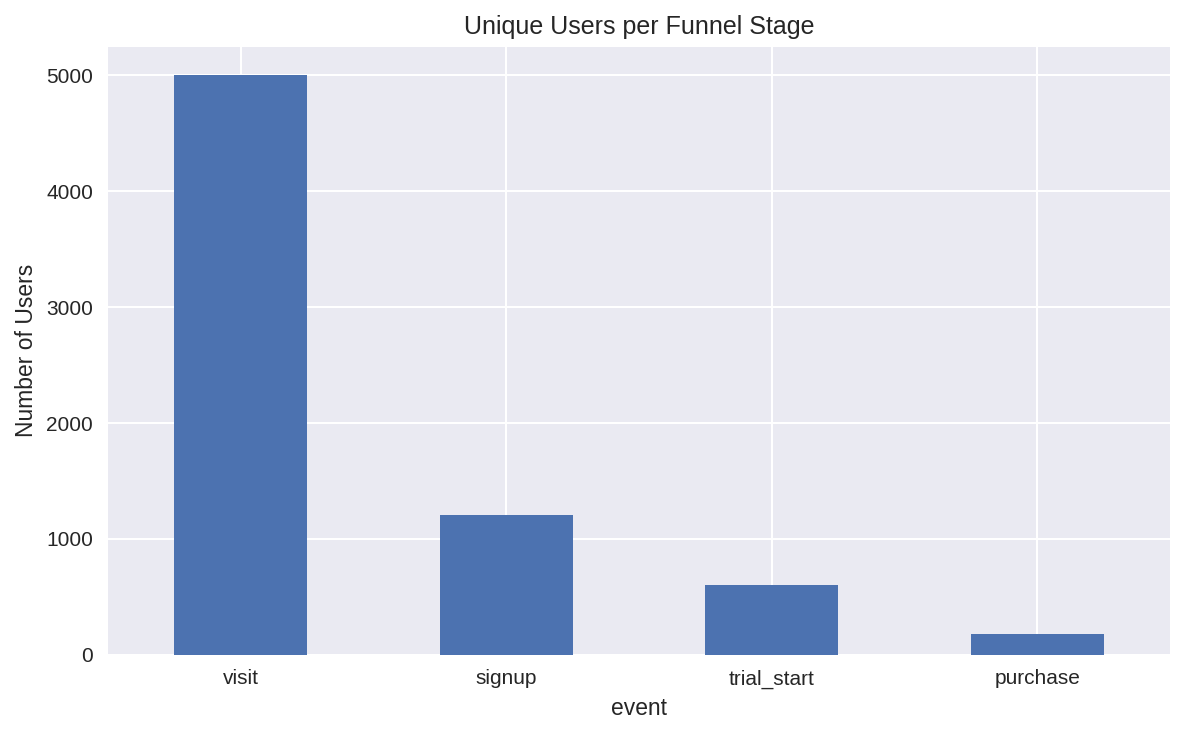

In [12]:
# ==============================
# Users per funnel stage
# ==============================

# Count unique users per event
users_per_stage = (
    df.groupby("event")["user_id"]
      .nunique()
      .reindex(["visit", "signup", "trial_start", "purchase"])
)

print(users_per_stage)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

users_per_stage.plot(kind="bar")

plt.title("Unique Users per Funnel Stage")
plt.ylabel("Number of Users")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

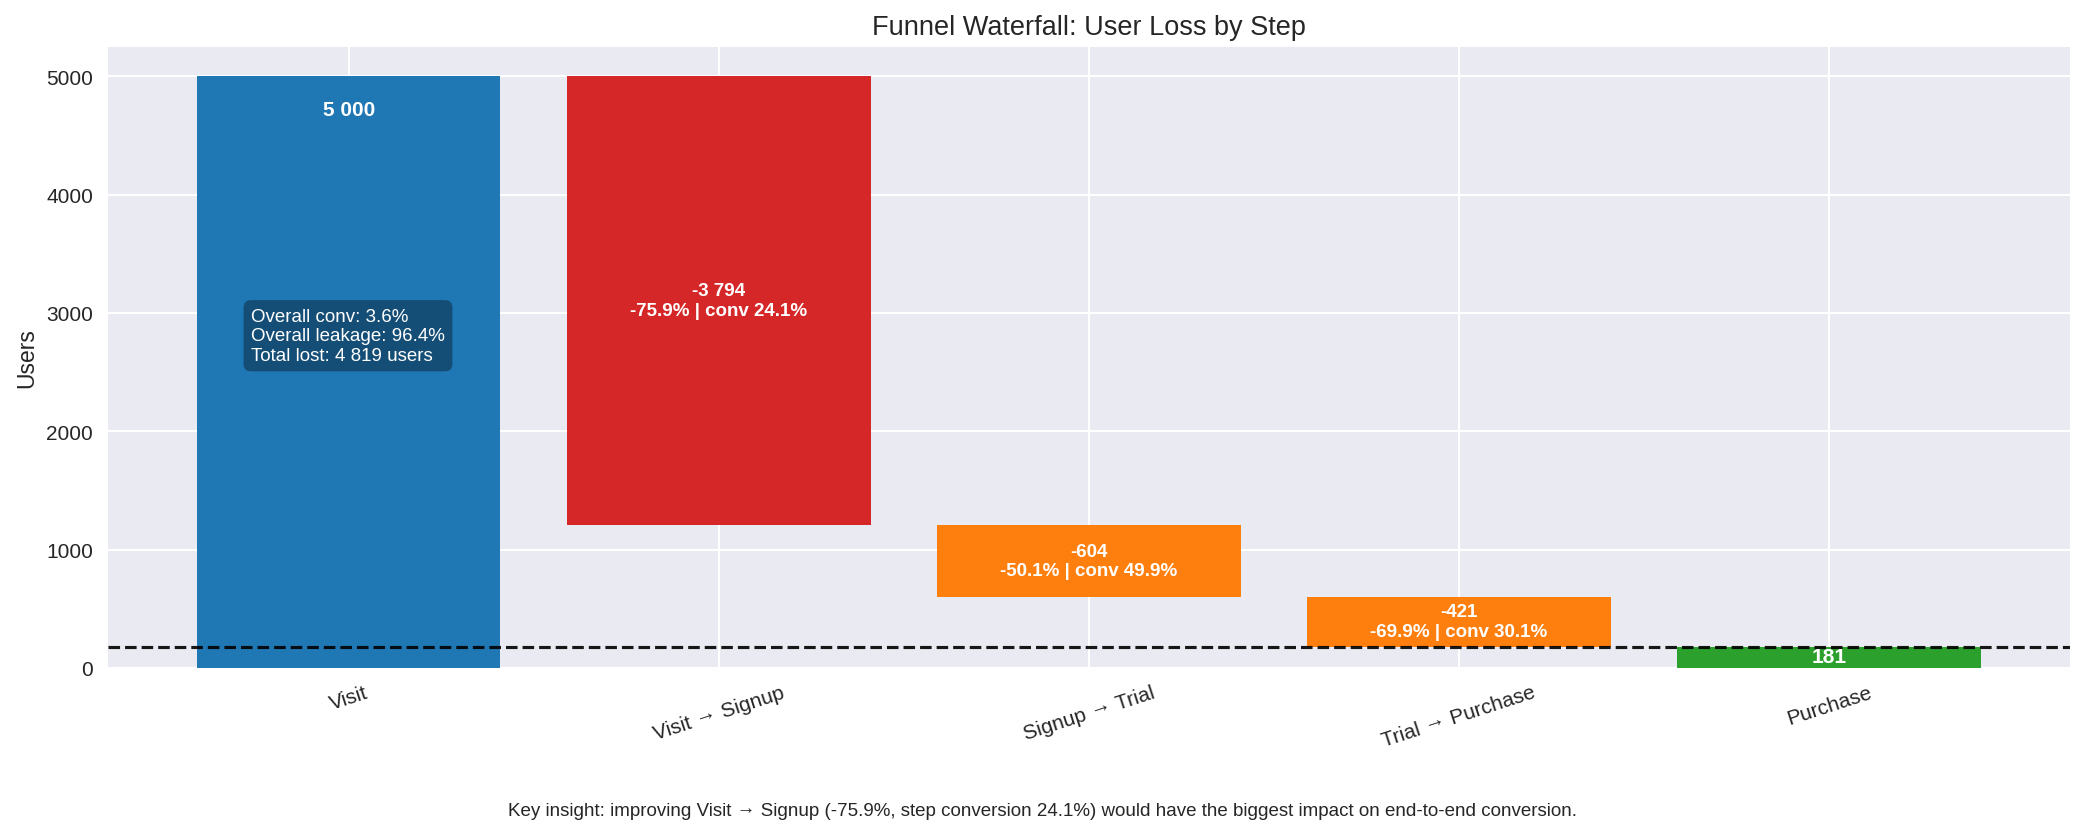

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Funnel Waterfall
# =========================

stage_order = ["visit", "signup", "trial_start", "purchase"]

users_per_stage = (
    df[df["event"].isin(stage_order)]
    .groupby("event")["user_id"]
    .nunique()
    .reindex(stage_order, fill_value=0)
)

visit_n, signup_n, trial_n, purchase_n = users_per_stage.tolist()

loss_1 = signup_n - visit_n
loss_2 = trial_n - signup_n
loss_3 = purchase_n - trial_n

conv_1 = (signup_n / visit_n) if visit_n else 0
conv_2 = (trial_n / signup_n) if signup_n else 0
conv_3 = (purchase_n / trial_n) if trial_n else 0

overall_conv = (purchase_n / visit_n) if visit_n else 0
overall_leak = 1 - overall_conv
total_lost = visit_n - purchase_n

labels = ["Visit", "Visit → Signup", "Signup → Trial", "Trial → Purchase", "Purchase"]
x = np.arange(len(labels))

heights = [visit_n, loss_1, loss_2, loss_3, purchase_n]
bottoms = [0, visit_n, signup_n, trial_n, 0]
colors = ["#1f77b4", "#d62728", "#ff7f0e", "#ff7f0e", "#2ca02c"]

# уменьшили высоту
plt.figure(figsize=(14, 5.6))
ax = plt.gca()

ax.bar(x, heights, bottom=bottoms, color=colors, edgecolor="none", width=0.82)

ax.set_title("Funnel Waterfall: User Loss by Step", fontsize=13)
ax.set_ylabel("Users")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=18)

ax.set_ylim(0, max(visit_n, 1) * 1.05)

# purchase reference line
ax.axhline(purchase_n, linestyle="--", linewidth=1.5, color="black", alpha=0.9)

def fmt_int(n: int) -> str:
    return f"{n:,}".replace(",", " ")

def fmt_pct(p: float) -> str:
    return f"{p*100:.1f}%"

def loss_block(loss_val, prev_n, next_n):
    leak = (-loss_val / prev_n) if prev_n else 0
    conv = (next_n / prev_n) if prev_n else 0
    return f"{fmt_int(loss_val)}\n-{fmt_pct(leak)} | conv {fmt_pct(conv)}"

# Visit / Purchase labels
ax.text(x[0], visit_n * 0.96, fmt_int(visit_n),
        ha="center", va="top", color="white",
        fontsize=10, fontweight="bold")

ax.text(x[4], purchase_n * 0.96, fmt_int(purchase_n),
        ha="center", va="top", color="white",
        fontsize=10, fontweight="bold")

# Loss labels
ax.text(x[1], visit_n - (visit_n - signup_n)/2,
        loss_block(loss_1, visit_n, signup_n),
        ha="center", va="center",
        color="white", fontsize=9, fontweight="bold")

ax.text(x[2], signup_n - (signup_n - trial_n)/2,
        loss_block(loss_2, signup_n, trial_n),
        ha="center", va="center",
        color="white", fontsize=9, fontweight="bold")

ax.text(x[3], trial_n - (trial_n - purchase_n)/2,
        loss_block(loss_3, trial_n, purchase_n),
        ha="center", va="center",
        color="white", fontsize=9, fontweight="bold")

# Overall box
box_text = (
    f"Overall conv: {fmt_pct(overall_conv)}\n"
    f"Overall leakage: {fmt_pct(overall_leak)}\n"
    f"Total lost: {fmt_int(total_lost)} users"
)

ax.text(
    0.073, 0.58,
    box_text,
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.4", fc="black", ec="none", alpha=0.35),
    color="white"
)

# --- KEY INSIGHT ---
step_names = ["Visit → Signup", "Signup → Trial", "Trial → Purchase"]
prevs = [visit_n, signup_n, trial_n]
nexts = [signup_n, trial_n, purchase_n]

leaks = [(1 - (n / p)) if p else 0 for p, n in zip(prevs, nexts)]
convs = [(n / p) if p else 0 for p, n in zip(prevs, nexts)]

worst_idx = int(np.argmax(leaks))
worst_step = step_names[worst_idx]
worst_leak = leaks[worst_idx]
worst_conv = convs[worst_idx]

insight = (
    f"Key insight: improving {worst_step} "
    f"(-{fmt_pct(worst_leak)}, step conversion {fmt_pct(worst_conv)}) "
    f"would have the biggest impact on end-to-end conversion."
)

plt.figtext(
    0.5, 0.015,
    insight,
    ha="center", va="bottom",
    fontsize=9
)

# tighter bottom space
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()

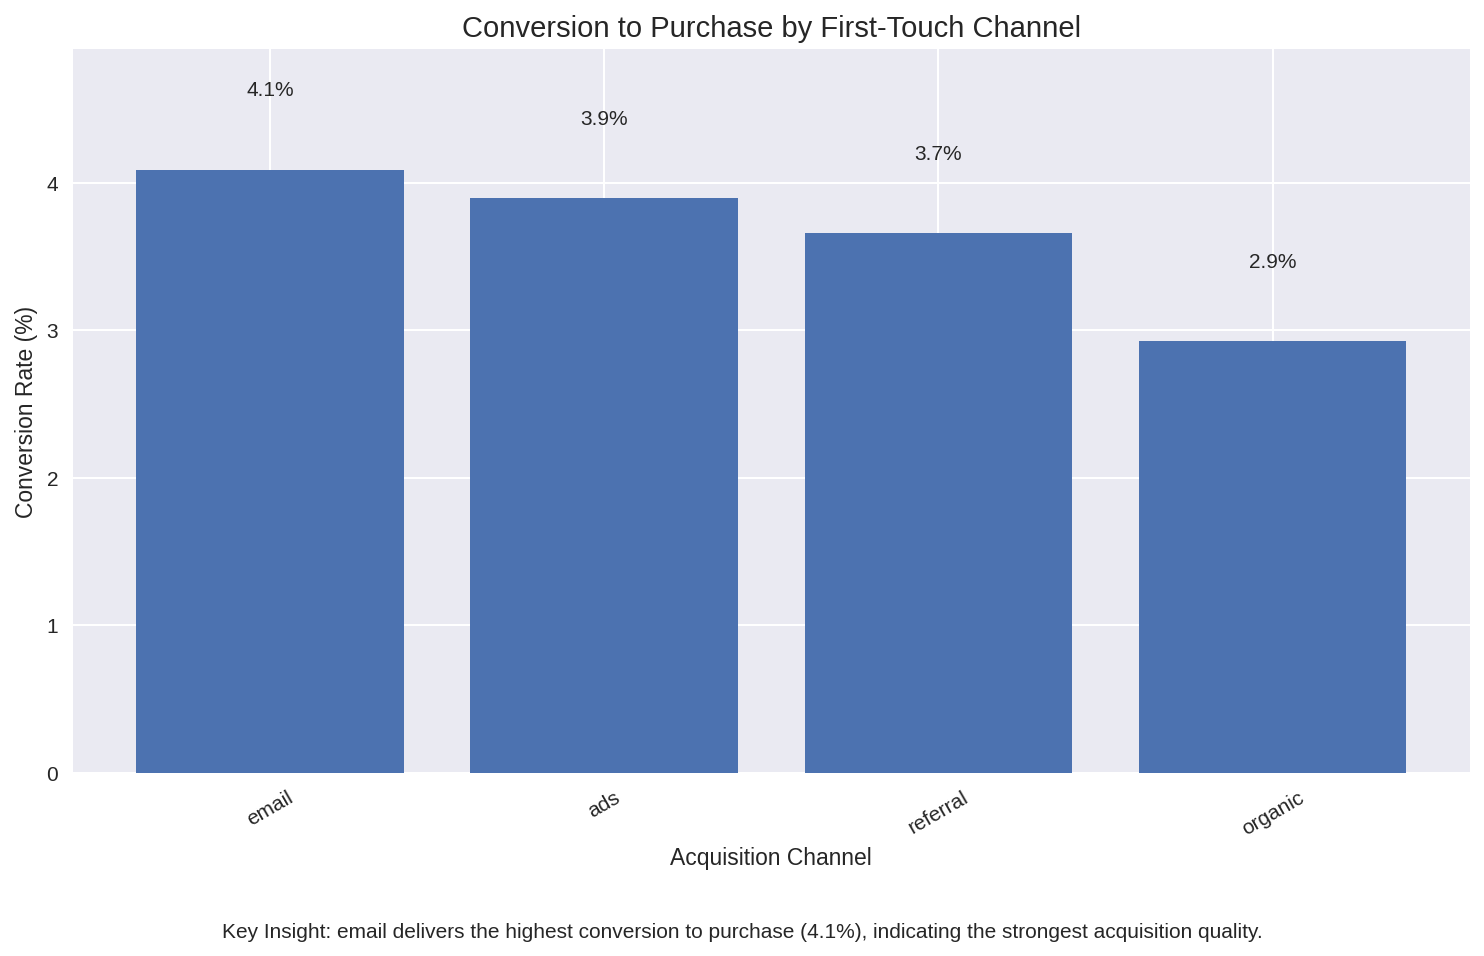

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. First-touch attribution ---
df_sorted = df.sort_values(["user_id", "timestamp"])

first_touch = (
    df_sorted.groupby("user_id")
    .first()
    .reset_index()[["user_id", "source"]]
)

# --- 2. Users with visit and purchase ---
user_events = (
    df.groupby(["user_id", "event"])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)

user_events["has_visit"] = user_events.get("visit", 0) > 0
user_events["has_purchase"] = user_events.get("purchase", 0) > 0

# --- 3. Merge first-touch ---
users = first_touch.merge(user_events, on="user_id")

# --- 4. Calculate conversion by source ---
summary = (
    users.groupby("source")
    .agg(
        visits=("has_visit", "sum"),
        purchases=("has_purchase", "sum")
    )
)

summary["conversion_rate"] = summary["purchases"] / summary["visits"]

summary = summary.sort_values("conversion_rate", ascending=False)

# --- 5. Plot ---
plt.figure(figsize=(10, 6))

bars = plt.bar(
    summary.index,
    summary["conversion_rate"] * 100
)

plt.title("Conversion to Purchase by First-Touch Channel", fontsize=14)
plt.ylabel("Conversion Rate (%)")
plt.xlabel("Acquisition Channel")
plt.ylim(0, summary["conversion_rate"].max() * 120)

plt.xticks(rotation=30)

# Labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        f"{height:.1f}%",
        ha='center'
    )

# --- Key Insight ---
best_channel = summary.index[0]
best_rate = summary["conversion_rate"].iloc[0] * 100

plt.figtext(
    0.5, -0.05,
    f"Key Insight: {best_channel} delivers the highest conversion "
    f"to purchase ({best_rate:.1f}%), indicating the strongest acquisition quality.",
    ha="center",
    fontsize=10
)

plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. First-touch source per user
# ---------------------------
first_touch = (
    df.sort_values("timestamp")
      .groupby("user_id")
      .first()[["source"]]
      .rename(columns={"source": "first_touch_source"})
      .reset_index()
)

df_ft = df.merge(first_touch, on="user_id", how="left")

# ---------------------------
# 2. Step-by-step funnel counts (first-touch attribution)
# ---------------------------
funnel_steps = ["visit", "signup", "trial_start", "purchase"]

funnel_counts = (
    df_ft[df_ft["event"].isin(funnel_steps)]
    .groupby(["first_touch_source", "event"])["user_id"]
    .nunique()
    .unstack(fill_value=0)
    .reindex(columns=funnel_steps)
)

# ---------------------------
# 3. Revenue aggregation
# ---------------------------
revenue_per_channel = (
    df_ft[df_ft["event"] == "purchase"]
    .groupby("first_touch_source")["revenue"]
    .sum()
)

paying_users_per_channel = (
    df_ft[df_ft["event"] == "purchase"]
    .groupby("first_touch_source")["user_id"]
    .nunique()
)

# ---------------------------
# 4. Build summary table
# ---------------------------
summary = funnel_counts.copy()

summary["total_revenue"] = revenue_per_channel
#summary["paying_users"] = paying_users_per_channel

summary = summary.fillna(0)

summary["ARPU"] = summary["total_revenue"] / summary["visit"]
#summary["ARPPU"] = summary["total_revenue"] / summary["paying_users"]
summary["ARPPU"] = summary["total_revenue"] / summary["purchase"]

summary = summary.replace([np.inf, -np.inf], 0)

summary = summary.sort_values("ARPU", ascending=False)

summary

event,visit,signup,trial_start,purchase,total_revenue,ARPU,ARPPU
first_touch_source,,,,,,,
ads,1978,479,236,77,4960.770280,2.507973,64.425588
email,1052,282,145,43,2377.940290,2.260400,55.300937
organic,1505,345,168,44,2730.504822,1.814289,62.056928
referral,465,100,53,17,749.048348,1.610857,44.061668


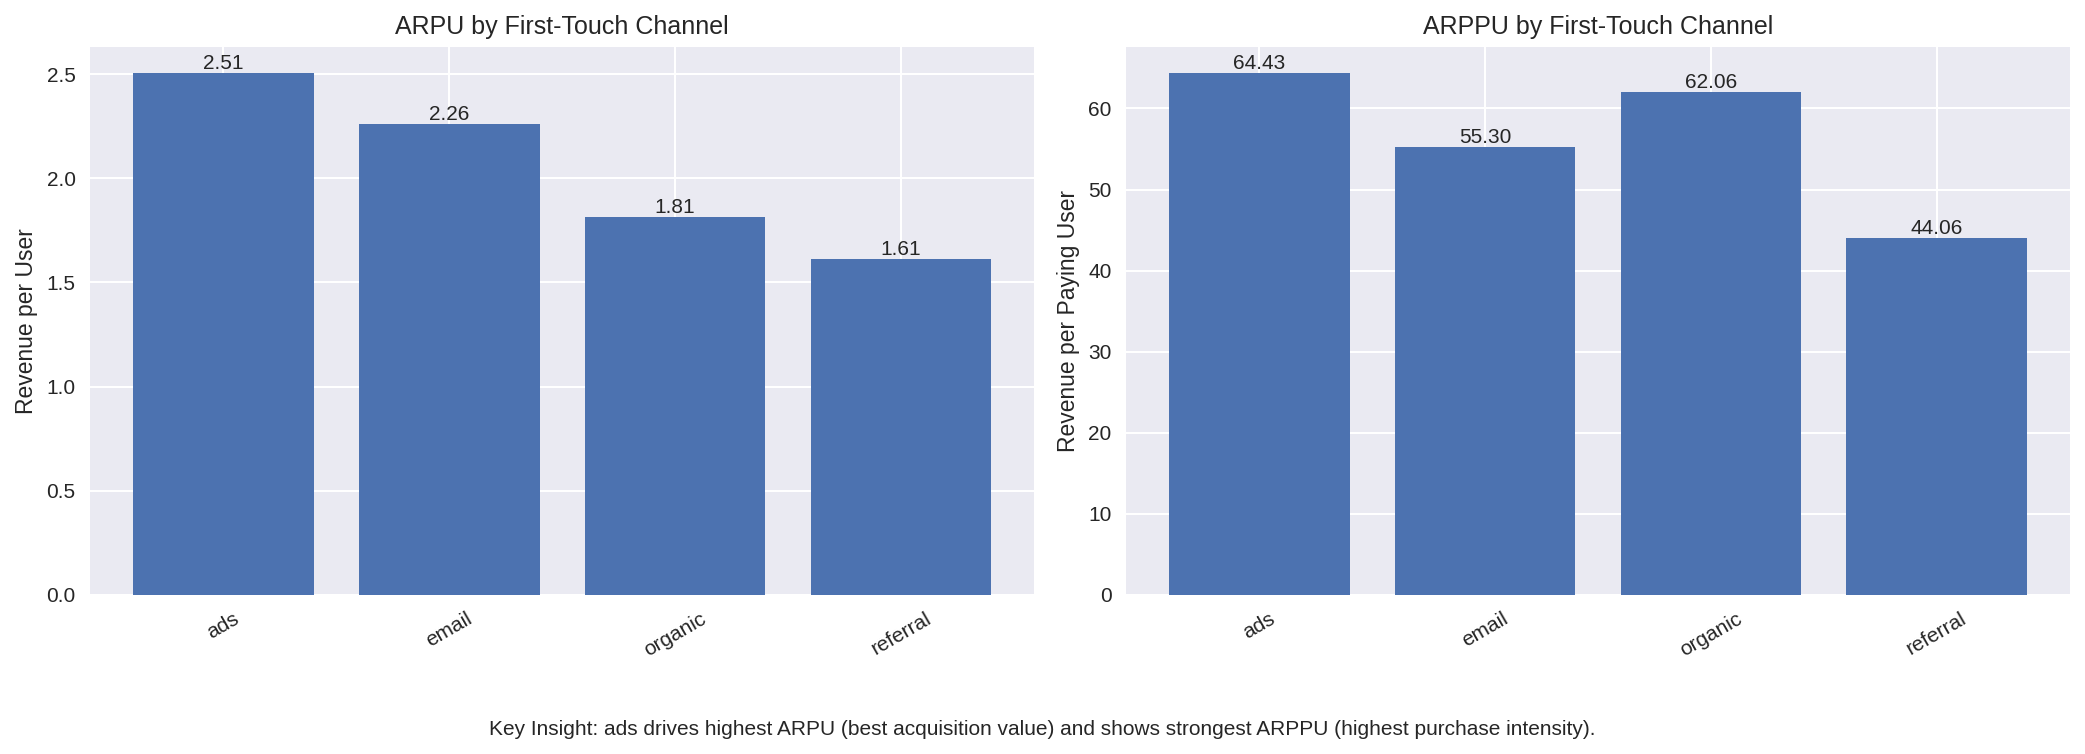

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- Panel 1: ARPU ----
axes[0].bar(summary.index, summary["ARPU"])
axes[0].set_title("ARPU by First-Touch Channel")
axes[0].set_ylabel("Revenue per User")
axes[0].tick_params(axis='x', rotation=30)

for i, v in enumerate(summary["ARPU"]):
    axes[0].text(i, v, f"{v:.2f}", ha="center", va="bottom")

# ---- Panel 2: ARPPU ----
axes[1].bar(summary.index, summary["ARPPU"])
axes[1].set_title("ARPPU by First-Touch Channel")
axes[1].set_ylabel("Revenue per Paying User")
axes[1].tick_params(axis='x', rotation=30)

for i, v in enumerate(summary["ARPPU"]):
    axes[1].text(i, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout(rect=[0, 0.08, 1, 1])

# ---- Key Insight
best_arpu_channel = summary["ARPU"].idxmax()
best_arppu_channel = summary["ARPPU"].idxmax()

fig.text(
    0.5,
    0.01,
    f"Key Insight: ads drives highest ARPU (best acquisition value) "
    f"and shows strongest ARPPU (highest purchase intensity).",
    ha="center",
    fontsize=10
)

plt.show()